In [24]:
#pip install scikits-bootstrap --user
#pip install pymicro --user
#pip install vtk --user

Basic imports

In [1]:
import os, glob, platform, sys
import numpy as np
import numpy.matlib
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from scipy import *
from matplotlib.pyplot import *

In [2]:
# Importing behavioral data from experiment 
sys_dir = os.path.join('/Users','leenfarah','Desktop')
proj_dir = os.path.join(sys_dir,'wm_prior','SResults')
os.chdir("/Users/leenfarah/Desktop/wm_prior/SResults/")
print(os.getcwd())

/Users/leenfarah/Desktop/wm_prior/SResults


In [34]:
# EXPERIMENT 2
# Importing behavioral data from experiment 
sys_dir = os.path.join('/Users','leenfarah','Desktop')
proj_dir = os.path.join(sys_dir,'wm_prior_exp2','results')
os.chdir("/Users/leenfarah/Desktop/wm_prior_exp2/results/")
print(os.getcwd())

/Users/leenfarah/Desktop/wm_prior_exp2/results


In [3]:
from random import shuffle, sample
from numpy.linalg import norm
import statsmodels.nonparametric.smoothers_lowess as loess
from scipy.io import *
from circ_stats import * 								# File needs to be in the wd
from time import time, sleep

%matplotlib inline

# mne libraries
import shutil as sh
import mne
from mne.datasets import eegbci
from pymicro.view.vol_utils import compute_affine_transform


__Reading the behavioral data__

Generating paths

In [4]:
#%% FUNCTIONS
def len2(x):
	if type(x) is not type([]):
		if type(x) is not type(array([])):
			return -1
	return len(x)

def circdist(angles1,angles2):
    if len2(angles2) < 0:
        if len2(angles1) > 0:
            angles2 = [angles2]*len(angles1)
        else:
            angles2 = [angles2]
            angles1 = [angles1]
    if len2(angles1) < 0:
        angles1 = [angles1]*len(angles2)
        
    return np.angle(exp(1j*angles1)/exp(1j*angles2))
        
    #return amap(lambda a1,a2: phase2(exp(1j*a1)/exp(1j*a2)), angles1,angles2)

def circ_mean(x):
	return circmean(x,low=-pi,high=pi)

def rem_sys_err(report,target,w):
    n=[]
    for x in arange(-pi,pi,w):
        d=circdist(target,x)
        idx = (d >= x) & (d<x+w)
        report[idx] = circdist(report[idx],circmean(circdist(report[idx],target[idx]),low=-pi,high=pi))
        n.append(sum(idx))
        
    return report,n

def rem_sys_err2(report,target,frac=.25):
    #''' Removes from the response the systematic error of the subject.'''
    fit_resp = loess.lowess(report, target, frac = frac, return_sorted = False)
    fit_error = circdist(fit_resp, target)
    clean_res = circdist(report, fit_error) # Clean response ?
    return clean_res

def circdist(angles1,angles2):       
    return np.angle(np.exp(1j*angles1)/np.exp(1j*angles2))

In [5]:
def vfilter(x, var):
    return x.loc[(abs(x[var] ) < 3*std(abs(x[var] ))) & (abs(x[var] ) > 1)]

In [6]:
def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True, color = 'C0'):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor=color, fill=False, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [7]:
all_df = pd.DataFrame([]) # concatenate all behav subject data together
ddata = pd.DataFrame([]) # concatenate here behav data + dv + orientations

In [8]:
# RUNNING PER PARTICIPANT
import os
import glob
import pandas as pd
import pickle

all_df = pd.DataFrame([]) # concatenate all behav subject data together
ddata = pd.DataFrame([]) # concatenate here behav data + dv + orientations

for file in sorted(glob.glob("*.psydat")):
    if file.startswith("leen"):  # check if the file name starts with S05
        subjdata = pd.DataFrame([]) # initialize individual subject data variable container
        pfile =  open(os.path.join(proj_dir, file),"rb")
        dat = pickle.load(pfile)
        for block in dat['main_exp']['Exp_blocks']:
            ddata = pd.DataFrame(block['data'])
            ddata.columns = ddata.iloc[0]
            ddata = ddata.iloc[1:,:]
            ddata.reset_index(drop=True, inplace=True)
            subjdata = pd.concat([subjdata, ddata], axis = 0)
        all_df = pd.concat([all_df, subjdata], axis = 0) #concatenate each new subject


In [9]:
pfile =  open(os.path.join(proj_dir, file), "rb")
dat = pickle.load(pfile)

In [10]:

all_df = pd.DataFrame([]) # concatenate all behav subject data together
ddata = pd.DataFrame([]) # concatenate here behav data + dv + orientations

for file in sorted(glob.glob("*.psydat")): 
    subjdata = pd.DataFrame([]) # initialize individual subject data variable container
    pfile =  open(os.path.join(proj_dir, file),"rb")
    dat = pickle.load(pfile)
    subjdata = pd.DataFrame([]) # initialize individual subject data variable container
    for block in dat['main_exp']['Exp_blocks']:
        ddata = pd.DataFrame(block['data'])
        ddata.columns = ddata.iloc[0]
        ddata = ddata.iloc[1:,:]
        ddata.reset_index(drop=True, inplace=True)
        subjdata = pd.concat([subjdata, ddata], axis = 0)
    
    
    all_df = pd.concat([all_df, subjdata], axis = 0) #concatenate each new subject


# changing the format of the prior column from array to value
all_df.reset_index(drop=True, inplace=True)
for i in range(len(all_df.prior)):
    try:
        all_df.prior[i] = all_df.prior[i][0]
    except:
        pass



# Here I am reaaranging orientations to fall between -180 and 180
all_df['T_Angle'] = all_df['T_Angle'].astype(float)

# remeber to remove the first trial of each block

all_df['preT'] = all_df['T_Angle'].shift(1) 
all_df['preT'] = all_df['preT'].astype(float)

all_df['choiceAngle'] = all_df['choiceAngle'].astype(float)
mask = (all_df['choiceAngle']>180)
df_valid = all_df[mask]
all_df.loc[mask, 'choiceAngle'] = df_valid['choiceAngle'] - 360
mask = (all_df['T_Angle']>180)
df_valid = all_df[mask]
all_df.loc[mask, 'T_Angle'] = df_valid['T_Angle'] - 360


all_df.reset_index(drop=True, inplace=True)

all_df.head(-4)

TypeError: 'NoneType' object is not subscriptable

Filtering data without catchtrials

__Creating bins for data plotting__

breaks = 20 # step size
bins = arange(-180,180+breaks,breaks)
bin_labels = []
for i in arange(len(bins)):
    #bin_labels.append(bins[i]+breaks/2)
    bin_labels.append(bins[i]+breaks/2)
bin_labels = bin_labels[:-1]

In [11]:
df = all_df[['subj','block','trial','prior','ct','delay','preT','T_Angle','choiceAngle','keypressed','RT']]

# removing preT nan values
df = df.dropna(subset=['preT'])
df = df[df['keypressed'] != 'space']
df.reset_index(drop=True, inplace=True)

df.insert(8, 'preDiff', np.rad2deg(circdist( np.deg2rad(df['preT']),np.deg2rad(df['T_Angle'])))) 
df['preDiff'] = df['preDiff'].astype(float)
df.insert(9, 'err', np.rad2deg(circdist( np.deg2rad(df['choiceAngle']),np.deg2rad(df['T_Angle'])))) 
df['prior'] = df['prior'].astype(float)

#df['bin_Tangle'] = pd.cut(df['T_Angle'], bins=bins, labels = bin_labels)
#df['bin_preDiff'] = pd.cut(df['preDiff'], bins=bins, labels = bin_labels)
#df['bin_err'] = pd.cut(df['err'], bins=bins, labels = bin_labels)
#df['bin_preDiff'] = df['bin_preDiff'].astype(float)


KeyError: "['preT'] not in index"

In [12]:
#%% PARAMETERS
flip = False
rm_bias = True
bins = {}
bins['step'] =  pi/50
bins['step_int'] =  pi/2
bins['x'] = arange(-pi,pi-bins['step_int']+bins['step'],bins['step'])


In [13]:
def compute_serial(x, report,target,ref_target,bins,flip=None, rm_bias = False, ref_report=False):
	report = radians(x[report])
	target = radians(x[target])
	if ref_target == 'null':
		ref_target = zeros(len(target))
	else:
		ref_target = radians(x[ref_target])
		
	xxx = bins['x']

	if rm_bias:
		report = rem_sys_err2(array(report),array(target))
		
	# calculating difference between estimates and targets	
	err = circdist(report,target)
	
	# a reference orientation - current cue (e.g. previous, 0 or prior)
	d = circdist(ref_target,target) #

	if ref_report:
		d=circdist(report[:-1],target[1:])
	
	# remove outliers
	idx_clean=(abs(err)<3*std((err))) & (abs(err)<1)
	#idx_clean = idx_clean & (report[1:] !=0)
	
	err=err[idx_clean]
	d=d[idx_clean]
	
	m_err=[]; std_err=[]; count=[]; cis=[]
	if flip:
		err = sign(d)*err
		d=abs(d)
	
	points_idx= []
	
	for t in xxx:
		idx=(d>=t)&(d<=t+bins['step_int'])
		m_err.append(circ_mean(err[idx]))
		std_err.append(circstd(err[idx])/sqrt(sum(idx)))
		#count.append(sum(idx))
		#points_idx.append(idx)
	
	x = xxx #+bins['step_int']
	out = pd.DataFrame([x ,m_err, std_err]).T
	out.columns=['x','m_err','std_err']
	
	return out


#  creating a bin with foor loops on:
# calculating the error 'err', which is the difference between the target and the report
# calculating the reference orientation 'd', which is the difference between 'ref_target' and 'target'
# removing the outliers 'idx_clean'
# overall having the output be the dataframe with additional oclumns of 'x', 'm_err', and 'std_err'




In [14]:
# to plot:
# choice angle vs target angle 
# serial dependence: choices are dependent on previous orientation of stimuli = correlation between choice angle and pevious choice angle 
# working memory bias: plot relationship between reference angle 'T_Angle' and choice angle 'choiceAngle'
# prior effects: relationsip between choice angle and prior


__Plotting histograms of T_angles per block types and subjects__ 

In [15]:
all_df.subj.unique()

array(['S01', 'S02', 'S03', 'S04'], dtype=object)

In [16]:
df_subj = df[df['subj'] == 'leen']                                                       # define which subject you want to analyse
priors = df_subj.prior.unique()

angles0 = np.deg2rad(df_subj[df_subj.prior ==  priors[0]].T_Angle)
angles1 = np.deg2rad(df_subj[df_subj.prior ==  priors[1]].T_Angle)
angles2 = np.deg2rad(df_subj[df_subj.prior ==  priors[2]].T_Angle)

# Construct figure and axis to plot on
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'))

# Visualise by area of bins
circular_hist(ax, angles0, color = 'blue')
circular_hist(ax, angles1, color = 'red')
circular_hist(ax, angles2, color = 'green')

# circular output = each colour codes for the different priors of where the stimuli was presented
# blue prior = 0, stimuli was randmly presented all over
# red prior = mean of where the stimuli was presented in that block 
# green prior = mean of where the stimuli was presented in that block


NameError: name 'df' is not defined

In [50]:
all_df.head()

,subj,trial,block,prior,kappa,ct,delay,fix,keypressed,R,...,ts_b,ts_f,ts_p,ts_d,ts_r,ts_e,m_pos_x,m_pos_y,m_clock,preT
0,leen,0,0,0,1,False,3000,True,None,11,...,1683554761.82436,1683554761.839058,1683554762.592077,1683554762.842072,1683554765.842058,1683554767.975399,"[-8.413300868900984, -8.413300868900984, -8.53...","[7.084884942232408, 7.084884942232408, 7.08488...","[0.0005317000000104599, 0.017400500000348984, ...",NaN
1,leen,1,0,0,1,False,3000,True,None,11,...,1683554768.738449,1683554768.755764,1683554769.509752,1683554769.758728,1683554772.758722,1683554774.12641,"[-10.184522104459086, -10.121264203189154, -10...","[4.206650434450492, 4.206650434450492, 4.26990...","[0.0003276999996160157, 0.017383299999892188, ...",-14.235676
2,leen,2,0,0,1,False,3000,True,None,11,...,1683554774.949816,1683554774.955749,1683554775.708714,1683554775.959711,1683554778.959731,1683554780.992703,"[-9.4254272892199, -9.4254272892199, -9.425427...","[-5.724840064928865, -5.724840064928865, -5.72...","[0.0006803999999647203, 0.018270399999892106, ...",131.500190
3,leen,3,0,0,1,False,3000,True,None,11,...,1683554781.713435,1683554781.7224,1683554782.475365,1683554782.725372,1683554785.725773,1683554788.72657,"[7.622577103026831, 7.622577103026831, 7.62257...","[-7.9072376587415265, -7.938866609376492, -7.9...","[0.00033540000003995374, 0.017493500000000495,...",-46.916553
4,leen,4,0,0,1,False,3000,True,None,11,...,1683554789.520459,1683554789.53905,1683554790.292017,1683554790.542014,1683554793.541992,1683554795.69301,"[10.15289315382412, 10.15289315382412, 10.1528...","[4.1750214838155255, 4.1750214838155255, 4.175...","[0.0003100000003541936, 0.017453800000112096, ...",-158.888375


In [51]:
test = df.groupby(['subj', 'prior']).apply(compute_serial,'choiceAngle','T_Angle','preT',bins,flip=None, rm_bias = False, ref_report=False) 
test.reset_index( inplace=True)
test['abs_err'] = abs(test.m_err)
test.x = rad2deg(test.x+bins['step_int']/2)

# grouping 'subj' and 'prior' and giving an output table of 'choiceAngle', 'T_Angle', and 'preT' and having the output be a new dataframe called 'test'
# add a new column in  the test dataframe called 'abs_err', which is the absolute error of the 'm_err' column in the test dataframe
# converts the x values in the test dataframe from radians to degrees


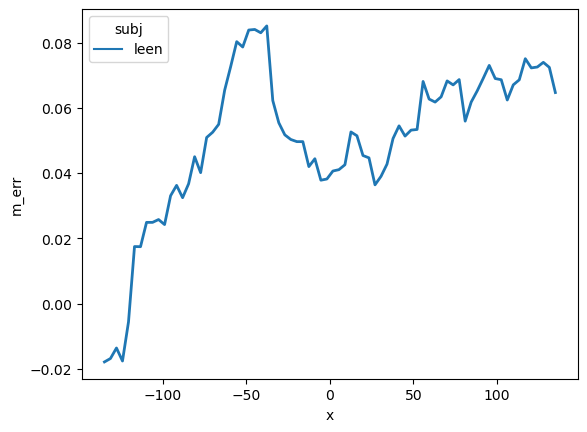

In [52]:
# filter data for any Ss only
#Ss = test[(test.subj == 'S22') & (test.prior == 0)]

# plot Ss data
#ax = sns.lineplot(data=Ss, x="x", y="m_err", linewidth=2)

# plot all Ss
ax = sns.lineplot(data=test[test.prior == 0], x="x", y="m_err",hue = 'subj',linewidth = 2)

# output displays that when the prior was at 0, what the response mean error was 
# for a perfect computer, we would see a horizontal line, that there is no mean error and that the value is always right 
# the peaks up or down show the systematic biases towards the previous stimulus
# potive or negative dips display distance and direction from the prior (the mean stimuli presented of the block)?

In [53]:
test = df.groupby(['subj', 'prior']).apply(compute_serial,'choiceAngle','T_Angle','prior',bins,flip=None, rm_bias = False, ref_report=False)
test.reset_index(inplace=True)
test['abs_err'] = abs(test.m_err)
test.x = rad2deg(test.x+bins['step_int']/2)

# grouping 'subj' and 'prior' and giving an output table of 'choiceAngle', 'T_Angle', and 'prior' and having the output be a new dataframe called 'test'
# add a new column in  the test dataframe called 'abs_err', which is the absolute error of the 'm_err' column in the test dataframe
# converts the x values in the test dataframe from radians to degrees

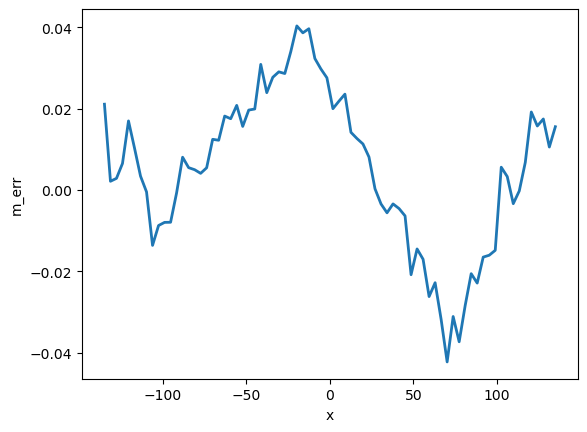

In [54]:
ax = sns.lineplot(data=test[test.prior != 0], x="x", y="m_err",linewidth = 2)

# output displays that when the prior was not at 0, what the response mean error was 
# when the priors are not equal to 0 and the mean error of that 

In [55]:
test = df.groupby(['subj', 'prior']).apply(compute_serial,'choiceAngle','T_Angle','null',bins,flip=None, rm_bias = False, ref_report=False)
test.reset_index( inplace=True)
test['abs_err'] = abs(test.m_err)
test.x = rad2deg(test.x+bins['step_int']/2)

# grouping 'subj' and 'prior' and giving an output table of 'choiceAngle', 'T_Angle', and 'null' and having the output be a new dataframe called 'test'

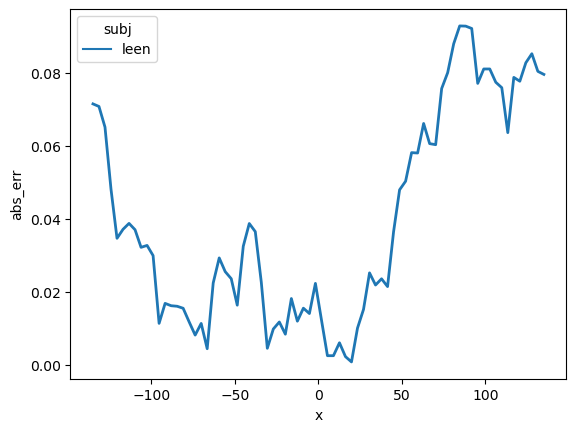

In [56]:
ax = sns.lineplot(data=test[test.prior == 0], x="x", y="abs_err", hue = 'subj', linewidth = 2)

# output displays that when the prior was at 0, what the absolute value of the error was (absolute values, so all positive)

(array([ 9., 10.,  9., 14.,  7., 12., 12., 13., 11.,  9.,  9., 14., 16.,
        13., 21., 11., 13.,  9., 19.,  8., 16., 20.,  8., 20., 16., 11.,
         5.,  6.,  6.,  6.,  6.,  8.,  6.,  1.,  4.,  6.,  7.,  2.,  3.,
         4.,  6.,  5.,  3.,  6.,  3., 10.,  5.,  6.,  6.,  5.]),
 array([-1.79073522e+02, -1.71910232e+02, -1.64746942e+02, -1.57583651e+02,
        -1.50420361e+02, -1.43257071e+02, -1.36093780e+02, -1.28930490e+02,
        -1.21767200e+02, -1.14603910e+02, -1.07440619e+02, -1.00277329e+02,
        -9.31140387e+01, -8.59507484e+01, -7.87874582e+01, -7.16241679e+01,
        -6.44608776e+01, -5.72975873e+01, -5.01342970e+01, -4.29710068e+01,
        -3.58077165e+01, -2.86444262e+01, -2.14811359e+01, -1.43178456e+01,
        -7.15455536e+00,  8.73491842e-03,  7.17202520e+00,  1.43353155e+01,
         2.14986058e+01,  2.86618960e+01,  3.58251863e+01,  4.29884766e+01,
         5.01517669e+01,  5.73150572e+01,  6.44783474e+01,  7.16416377e+01,
         7.88049280e+01,  8.5968

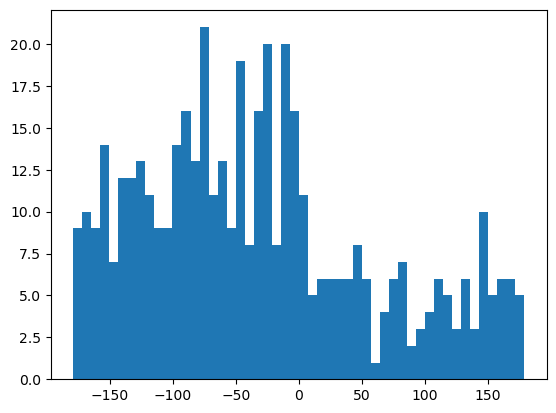

In [57]:
plt.hist((df.T_Angle), bins=50)             # plot histogram of all subjects

#df_subj = df[df['subj'] == 'S02']           # if you do not want to plt for all subjects, define the subject
#plt.hist(df_subj['T_Angle'], bins=50)       # plt the histogram for the subject you previously defined

# bins 50 means that the T_Angle will be divided into 50 interval bins
# x axis = the T_Angles
# y axis = the frequency of those angles

[9.98787420e-01 8.57310553e-05 9.76270560e-01]


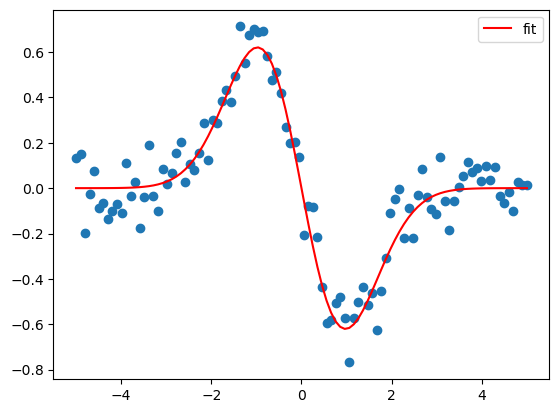

In [58]:
from scipy.optimize import curve_fit

def derivative_gaussian(x, A, mu, sigma):
    return -A * (x - mu) * np.exp(-(x - mu)**2 / (2 * sigma**2)) / sigma**2

# Generate some example data
x_data = np.linspace(-5, 5, 100)
y_data = derivative_gaussian(x_data, 1, 0, 1) + np.random.normal(0, 0.1, 100)

# Fit the function to the data
popt, pcov = curve_fit(derivative_gaussian, x_data, y_data)

# Print the optimized parameters
print(popt)

# Plot the original data and the fitted curve
import matplotlib.pyplot as plt
plt.scatter(x_data, y_data)
plt.plot(x_data, derivative_gaussian(x_data, *popt), 'r-', label='fit')
plt.legend()
plt.show()

# plot a gaussian curve with 100 evenly spaced points from -5 to 5
# evaluate the pints in x_data with an amplitude of 1, mean 0, and standard deviation of 1 
# popt are the optimal values, and we are printing the optimized paramaters
# output shows a scatterplott generated with the data of x_data and y_data, and a gaussian curve to fit the function


In [59]:
compute_serial(df, 'choiceAngle','T_Angle','preT',bins,flip=None, rm_bias = False, ref_report=False)

,x,m_err,std_err
0,-3.141593,-0.025415,0.014803
1,-3.078761,-0.032981,0.016089
2,-3.015929,-0.031663,0.016055
3,-2.953097,-0.032100,0.015887
4,-2.890265,-0.025264,0.015639
...,...,...,...
71,1.319469,0.038670,0.015110
72,1.382301,0.037323,0.015047
73,1.445133,0.038823,0.015334
74,1.507964,0.040699,0.015165


In [62]:
report = radians(df.choiceAngle)
target = radians(df.T_Angle)
ref_target = radians(df.preT)

/var/folders/r9/cr9dfv5j4v9ghnsqpsk0syy40000gn/T/ipykernel_7722/2893488765.py:2: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  ax = sns.lineplot(data=sys_eff, x="x", y="m_err", hue = 'delay', linewidth = 2, palette = ['red', 'blue'])
/var/folders/r9/cr9dfv5j4v9ghnsqpsk0syy40000gn/T/ipykernel_7722/2893488765.py:3: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(data=sys_eff, x="x", y="m_err", hue = 'delay', ax = ax, palette = ['red', 'blue'], alpha = 0.5, s = 1, legend = False)


([<matplotlib.axis.YTick at 0x1457a9070>,
 [Text(0, -10, '−10'),
  Text(0, -5, '−5'),
  Text(0, 0, '0'),
  Text(0, 5, '5'),
  Text(0, 10, '10')])

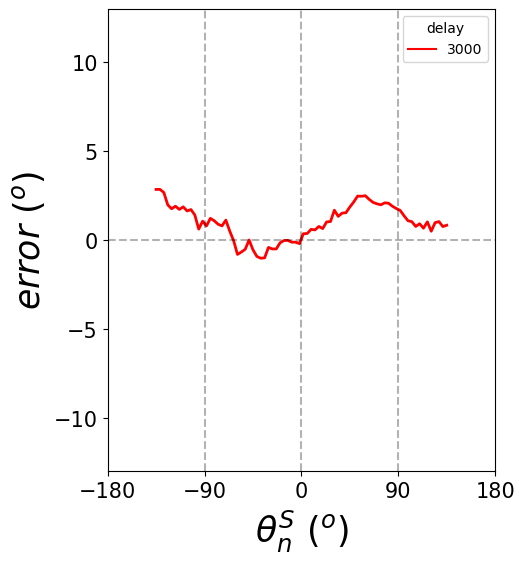

In [73]:
fig, axes = plt.subplots(1,1, figsize=(5,6))
ax = sns.lineplot(data=sys_eff, x="x", y="m_err", hue = 'delay', linewidth = 2, palette = ['red', 'blue'])
sns.scatterplot(data=sys_eff, x="x", y="m_err", hue = 'delay', ax = ax, palette = ['red', 'blue'], alpha = 0.5, s = 1, legend = False)
ax.axvline(0, ls='--', color= 'black', alpha=0.3)
ax.axvline(-90, ls='--', color= 'black', alpha=0.3)
ax.axvline(90, ls='--', color= 'black', alpha=0.3)
ax.axhline(0, ls='--', color= 'black', alpha=0.3)
ax.set_xlabel(r'$\theta_n^S$ ($^o$)', fontdict={'size':25}, labelpad=5); #plt.xticks(np.arange(-180, 181, step=90), fontsize = 15)
ax.set_ylabel(r'$error$ ($^o$)', fontdict={'size':25}, labelpad=5); plt.xticks(np.arange(-180, 181, step=90), fontsize = 15)
plt.ylim([-13, 13]); plt.yticks(np.arange(-10, 11, step=5), fontsize = 15)

In [69]:
#%% PARAMETERS
flip = False
rm_bias = False
bins = {}
bins['step'] =  pi/50
bins['step_int'] =  pi/2
bins['x'] = arange(-pi,pi-bins['step_int']+bins['step'],bins['step'])

In [71]:
preT_eff = df.groupby(['contrast',  'delay']).apply(compute_serial,'choiceAngle','T_Angle','preT',bins,flip=flip, rm_bias = False, ref_report=False)
preT_eff.reset_index( inplace=True)
preT_eff.m_err = rad2deg(preT_eff.m_err)
preT_eff['abs_err'] = abs(preT_eff.m_err)
preT_eff.x = rad2deg(preT_eff.x+bins['step_int']/2)

KeyError: 'contrast'

/var/folders/r9/cr9dfv5j4v9ghnsqpsk0syy40000gn/T/ipykernel_7722/3531303225.py:1: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  ax = sns.lineplot(data=preT_eff, x="x", y="m_err",hue = 'delay', linewidth = 2, palette = ['red', 'blue']) # [preT_eff.prior == 0]


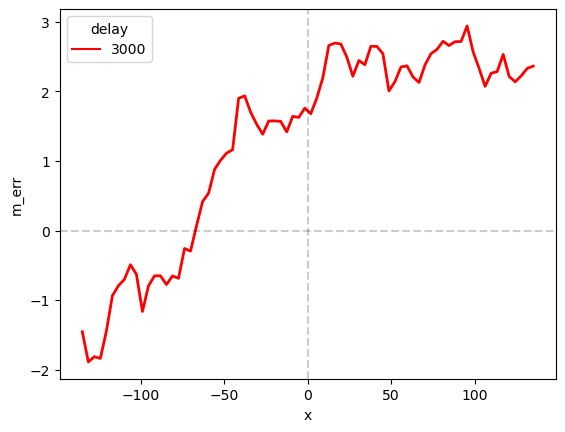

In [75]:
ax = sns.lineplot(data=preT_eff, x="x", y="m_err",hue = 'delay', linewidth = 2, palette = ['red', 'blue']) # [preT_eff.prior == 0]
ax.axvline(0, ls='--', color= 'black', alpha=0.2)
ax.axhline(0, ls='--', color= 'black', alpha=0.2)

In [79]:
preT_eff = df.groupby(['subj',  'delay']).apply(compute_serial,'choiceAngle','T_Angle','preT',bins,flip=flip, rm_bias = False, ref_report=False)
preT_eff.reset_index( inplace=True)
preT_eff.m_err = rad2deg(preT_eff.m_err)
preT_eff['abs_err'] = abs(preT_eff.m_err)
preT_eff.x = rad2deg(preT_eff.x+bins['step_int']/2)

/var/folders/r9/cr9dfv5j4v9ghnsqpsk0syy40000gn/T/ipykernel_7722/3531303225.py:1: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  ax = sns.lineplot(data=preT_eff, x="x", y="m_err",hue = 'delay', linewidth = 2, palette = ['red', 'blue']) # [preT_eff.prior == 0]


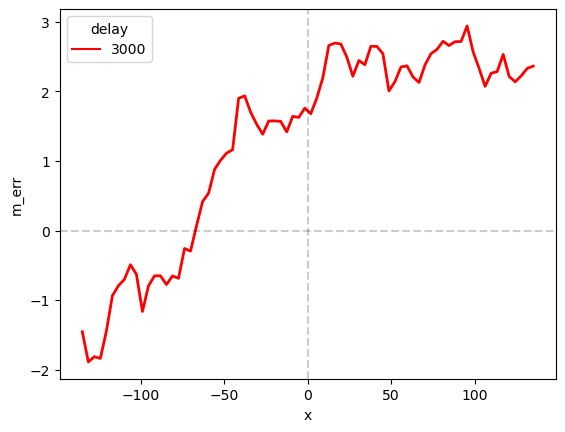

In [81]:
ax = sns.lineplot(data=preT_eff, x="x", y="m_err",hue = 'delay', linewidth = 2, palette = ['red', 'blue']) # [preT_eff.prior == 0]
ax.axvline(0, ls='--', color= 'black', alpha=0.2)
ax.axhline(0, ls='--', color= 'black', alpha=0.2)

In [85]:
posT_eff = df.groupby(['subj', 'delay']).apply(compute_serial,'choiceAngle','T_Angle','posT',bins,flip=flip, rm_bias = False, ref_report=False)
posT_eff.reset_index(inplace=True)
posT_eff['abs_err'] = abs(posT_eff.m_err)
posT_eff.m_err = rad2deg(posT_eff.m_err)
posT_eff.x = rad2deg(posT_eff.x+bins['step_int']/2)

KeyError: 'posT'

In [83]:
seq_eff = preT_eff.copy()
seq_eff['m_err'] = preT_eff.m_err - posT_eff.m_err

NameError: name 'posT_eff' is not defined

NameError: name 'seq_eff' is not defined

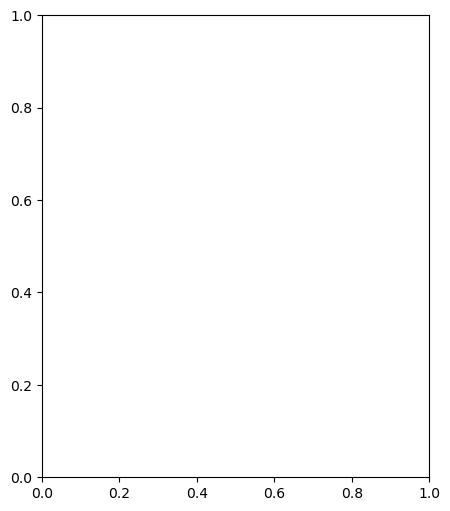

In [76]:
fig, axes = plt.subplots(1,1, figsize=(5,6))
ax = sns.lineplot(data=seq_eff, x="x", y="m_err", hue = 'delay', linewidth = 2, palette = ['red', 'blue'])
#sns.scatterplot(data=seq_eff, x="x", y="m_err", hue = 'delay', ax = ax, palette = ['red', 'blue'], alpha = 0.5, s = 1, legend = False)
ax.axvline(0, ls='--', color= 'black', alpha=0.3)
ax.axvline(-90, ls='--', color= 'black', alpha=0.3)
ax.axvline(90, ls='--', color= 'black', alpha=0.3)
ax.axhline(0, ls='--', color= 'black', alpha=0.3)

ax.set_xlabel(r'$\theta_{n-1}^S - \theta_n^S$ ($^o$)', fontdict={'size':25}, labelpad=5); #plt.xticks(np.arange(-180, 181, step=90), fontsize = 15)
ax.set_ylabel(r'$error$ ($^o$)', fontdict={'size':25}, labelpad=5); plt.xticks(np.arange(-180, 181, step=90), fontsize = 15)
plt.ylim([-3,3]); plt.yticks(np.arange(-2, 3, step=2), fontsize = 15)

In [86]:
test = df.groupby(['contrast', 'prior']).apply(compute_serial,'choiceAngle','T_Angle','prior',bins,flip=None, rm_bias = False, ref_report=False)
test.reset_index(inplace=True)
test['abs_err'] = abs(test.m_err)
test.x = rad2deg(test.x+bins['step_int']/2)

# grouping 'subj' and 'prior' and giving an output table of 'choiceAngle', 'T_Angle', and 'prior' and having the output be a new dataframe called 'test'
# add a new column in  the test dataframe called 'abs_err', which is the absolute error of the 'm_err' column in the test dataframe
# converts the x values in the test dataframe from radians to degrees

KeyError: 'contrast'

In [63]:
err = circdist(report,target)
d = circdist(ref_target,target) #a reference orientation - current cue (e.g. previous, 0 or prior)
err = radians(df.err)
d = radians(df.preDiff)
# remove outliers
idx_clean=(abs(err)<3*std((err))) & (abs(err)<1)
#idx_clean = idx_clean & (report[1:] !=0)

err=err[idx_clean]
d=d[idx_clean]
m_err=[]
std_err=[]
count=[]
cis=[]
if flip:
	err = sign(d)*err
	d=abs(d)
points_idx=[]
for t in xxx:
	idx=(d>=t)&(d<=t+w2)
	m_err.append(circ_mean(err[idx]))
	std_err.append(circstd(err[idx])/sqrt(sum(idx)))
	count.append(sum(idx))
	points_idx.append(idx)


NameError: name 'xxx' is not defined

In [67]:
plt.plot(np.rad2deg(xxx+w2/2),np.rad2deg(m_err))

# output would be plotting mean error in degrees

NameError: name 'xxx' is not defined

In [68]:
def circ_stats(dat,x,y): # this function was used to calculate the log linear regression between two vectors
    x = circ_mean(np.deg2rad(dat[x]))
    y = circ_mean(np.deg2rad(dat[y]))
    #std_err = circstd(np.deg2rad(dat[y])) #/sqrt(len(dat[y]))	 'std_err': std_err
    out = pd.DataFrame({'x': x , 'y': y}, index=[0])
    return out 

# calculate the circular mean of 'x' and 'y' in the output dataset of 'out'

In [69]:
test = df.groupby(['subj','bin_Tangle']).apply(circ_stats)

# for 'subj' and 'bin_Tangle' create an output table of 'test' and apply the circular statitics functin on them, adding the columns 'ref', 'pred', and 'std_err'

KeyError: 'bin_Tangle'

In [51]:
#%% PARAMETERS
w1=pi/50
w2=pi/2
xxx=arange(-pi,pi-w2+w1,w1)
flip = False
rm_bias =True

1. Calcula valores de error en funcion de trial anterior para cada triangular
2. Calcula valores en funcion del prior

In [50]:
prior = priors[0]
print(prior)
dat_s = df[(df['subj'] == 'S01') & (df['prior'] == prior)]
dat_s['preT'] = dat_s['T_Angle'].shift(1)
dat_s.reset_index(drop=True, inplace=True)

# make prior = 0
# create new dataframe called dat_s, where it gets the rows from 'df' where 'subj' is S01, and where 'prior' is 'prior', which is 0
# add a new clumn to dat_s called 'preT', which cocntans the values of 'T_Angle' shifted by 1 

0.0


/var/folders/r9/cr9dfv5j4v9ghnsqpsk0syy40000gn/T/ipykernel_15930/378475445.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_s['preT'] = dat_s['T_Angle'].shift(1)


In [59]:
err,d,m_err,std_err,count,points_idx = compute_serial(R,T,REF,xxx,flip,rm_bias,False)




IndexError: arrays used as indices must be of integer (or boolean) type

In [60]:
dat = dat_s.copy()
#sns.set_context('poster')
T = radians(array(dat['T_Angle']))
R = radians(array(dat['choiceAngle']))
P = radians(array(dat['preT']))


figure(figsize=[5,5])
#plt.subplot(4,1,isubj+1)
xxx=arange(-pi,pi-w2+w1,w1)
flip = False

#REF = P
REF = radians(prior*np.ones(np.shape(R)))
#REF = np.zeros(np.shape(R))

err,d,m_err,std_err,count,points_idx = compute_serial(R,T,REF,xxx,flip,rm_bias,False)


m_err=rad2deg(m_err)
std_err=rad2deg(std_err)

# Plot
plot(rad2deg(xxx+w2/2),m_err,linewidth=1.5)
fill_between(rad2deg(xxx+w2/2), m_err + std_err, m_err - std_err,alpha=.2)
plot(rad2deg(xxx+w2/2),zeros(len(xxx)),"k--",linewidth=1)
xlabel(r'$\theta_{n-1}^S - \theta_n^S$ ($^o$)', fontsize=14); ylabel(r'$\theta_n^e$ ($^o$)', fontsize=14);
sns.despine()


adict={}
adict['m_err']=m_err
adict['std_err']=std_err
adict['xxx']=xxx
adict['w2']=w2

IndexError: arrays used as indices must be of integer (or boolean) type

<Figure size 500x500 with 0 Axes>

In [278]:
dat = df.copy()
#sns.set_context('poster')
T = radians(array(dat['T_Angle']))
R = radians(array(dat['choiceAngle']))
P = radians(array(dat['preT']))


figure(figsize=[5,5])
#plt.subplot(4,1,isubj+1)
xxx=arange(-pi,pi-w2+w1,w1)
flip = False

REF = P
#REF = radians(prior*np.ones(np.shape(R)))
#REF = np.zeros(np.shape(R))

err,d,m_err,std_err,count,points_idx = compute_serial(R,T,REF,xxx,flip,rm_bias,False)


m_err=rad2deg(m_err)
std_err=rad2deg(std_err)

# Plot
plot(rad2deg(xxx+w2/2),m_err,linewidth=1.5)
fill_between(rad2deg(xxx+w2/2), m_err + std_err, m_err - std_err,alpha=.2)
plot(rad2deg(xxx+w2/2),zeros(len(xxx)),"k--",linewidth=1)
xlabel(r'$\theta_{n-1}^S - \theta_n^S$ ($^o$)', fontsize=14); ylabel(r'$\theta_n^e$ ($^o$)', fontsize=14);
sns.despine()


adict={}
adict['m_err']=m_err
adict['std_err']=std_err
adict['xxx']=xxx
adict['w2']=w2

IndexError: arrays used as indices must be of integer (or boolean) type

<Figure size 500x500 with 0 Axes>

In [37]:
breaks = 30 # step size
bins = arange(-180,180+breaks,breaks)
bin_labels = []
for i in arange(len(bins)):
    #bin_labels.append(bins[i]+breaks/2)
    bin_labels.append(bins[i]+breaks/2)
bin_labels = bin_labels[:-1]

# set bins to 30 and arranges the values from -180 to 180 degrees in steps of 30
# 'bin_labels' would be the adjacet midpoinnt of each pair of bin edges


In [38]:
df = all_df[['subj','block','trial','prior','ct','delay','preT','T_Angle','choiceAngle','keypressed','RT']]
df['bin_Tangle'] = pd.cut(df['T_Angle'], bins=bins, labels = bin_labels)

# removing preT nan values
df = df.dropna(subset=['preT'])
df = df[df['keypressed'] != 'space']


df.insert(8, 'preDiff', np.rad2deg(circdist( np.deg2rad(df['preT']),np.deg2rad(df['T_Angle'])))) 
df.insert(9, 'err', np.rad2deg(circdist( np.deg2rad(df['choiceAngle']),np.deg2rad(df['T_Angle'])))) 

df['bin_preDiff'] = pd.cut(df['preDiff'], bins=bins, labels = bin_labels)
df['bin_err'] = pd.cut(df['err'], bins=bins, labels = bin_labels)
df['bin_preDiff'] = df['bin_preDiff'].astype(float)
df['preDiff'] = df['preDiff'].astype(float)
df.reset_index(drop=True, inplace=True)

# select all columns from df thatt are 'subj','block','trial','prior','ct','delay','preT','T_Angle','choiceAngle','keypressed','RT'
# create new column in df called 'bin_Tangle' that uses the bin_labels from previous chunk
# remove in preT where key pressed is space and NaN
# 'preDiff' = circular distance between 'preT' and 'T_Angle'
# 'err' = circular distance between 'choiceAngle' and 'T_Angle'
# in df add columns 'bin_preDiff' and 'bin_err'

/var/folders/r9/cr9dfv5j4v9ghnsqpsk0syy40000gn/T/ipykernel_15930/1201712060.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bin_Tangle'] = pd.cut(df['T_Angle'], bins=bins, labels = bin_labels)


In [290]:
df.head()

,subj,block,trial,prior,ct,delay,preT,T_Angle,preDiff,err,choiceAngle,keypressed,RT,bin_Tangle,bin_preDiff,bin_err
0,S01,0,1,0,True,3000,77.308098,139.469019,-62.160921,9.760981,149.23,None,5.749991,135.0,-75.0,15.0
1,S01,0,2,0,True,1000,139.469019,78.503047,60.965972,-4.753047,73.75,None,4.33456,75.0,75.0,-15.0
2,S01,0,3,0,False,3000,78.503047,-111.634428,-169.862525,-9.785572,-121.42,None,4.166987,-105.0,-165.0,-15.0
3,S01,0,4,0,False,3000,-111.634428,-163.381749,51.747321,14.151749,-149.23,None,3.150066,-165.0,45.0,15.0
4,S01,0,5,0,False,1000,-163.381749,-35.046439,-128.335310,-12.623561,-47.67,None,6.366445,-45.0,-135.0,-15.0


In [39]:
def circ_stats(dat,x,y): # this function was used to calculate the log linear regression between two vectors
    ref = np.rad2deg(circ_mean(np.deg2rad(dat[x])))
    pred = np.rad2deg(circ_mean(np.deg2rad(dat[y])))
    std_err = np.rad2deg(circstd(np.deg2rad(dat[y]))) #/sqrt(len(dat[y]))	
    out = pd.DataFrame({'ref': ref , 'pred': pred, 'std_err': std_err}, index=[0])
    return out 

In [40]:
test = df.groupby(['subj','bin_Tangle']).apply(circ_stats, x = 'T_Angle', y = 'err')
test.reset_index(inplace=True)
test['lb'] = test.pred - test.std_err
test['hb'] = test.pred + test.std_err

# computes ccircular statisitcs for 'T_Angle' and 'err' for each level of 'subj' and 'bin_Tangle'
# compute confidence intervals for the circular mean of the 'err'
# lower bound is the circular mean - the standard error of the circular mean
# upper bound is the circular mean + the standard error of the circular mean



In [41]:
def circ_stats(dat,x,y): # this function was used to calculate the log linear regression between two vectors
    ref = np.rad2deg(circ_mean(np.deg2rad(dat[x])))
    pred = np.rad2deg(circ_mean(np.deg2rad(dat[y])))
    std_err = np.rad2deg(circstd(np.deg2rad(dat[y]))) #/sqrt(len(dat[y]))	
    out = pd.DataFrame({'ref': ref , 'pred': pred, 'std_err': std_err}, index=[0])
    return out 

# 'ref' = circular mean of 'x'
# 'pred' = circular mean of 'y'
# 'std_err' = standrd error of the circular mean of 'y'


In [42]:
def circ_stats(dat): # this function was used to calculate the log linear regression between two vectors
    ref = np.rad2deg(circ_mean(np.deg2rad(dat.preDiff)))
    pred = np.rad2deg(circ_mean(np.deg2rad(dat.err)))
    std_err = np.rad2deg(circstd(np.deg2rad(dat.err))) #/sqrt(len(dat[y]))	
    out = pd.DataFrame({'ref': ref , 'pred': pred, 'std_err': std_err}, index=[0])
    return out 

# 'ref' = circuclar mean of 'preDiff'
# pred' = circular mean of 'err' 
# 'std_err' = standard error of the circuclar mean of 'err'

In [44]:
test = df.groupby(['bin_preDiff']).apply(circ_stats)
#test.ref = np.rad2deg(test.ref)
#test.pred = np.rad2deg(test.pred)
test.reset_index(inplace=True)
test['lb'] = test.pred - test.std_err
test['hb'] = test.pred + test.std_err


In [43]:
ax = sns.lineplot(data=test, x="bin_preDiff", y="pred",linewidth = 2)

ValueError: Could not interpret value `bin_preDiff` for parameter `x`

In [45]:
df['bin_preDiffbinrads'] = np.deg2rad(df.bin_preDiff)
df['err_rads'] = np.deg2rad(df.err)

In [46]:
df.columns

Index(['subj', 'block', 'trial', 'prior', 'ct', 'delay', 'preT', 'T_Angle',
       'preDiff', 'err', 'choiceAngle', 'keypressed', 'RT', 'bin_Tangle',
       'bin_preDiff', 'bin_err', 'bin_preDiffbinrads', 'err_rads'],
      dtype='object', name=0)

In [47]:
df.bin_preDiffbinrads == t

NameError: name 't' is not defined

In [48]:
df[df.bin_preDiffbinrads == t ].err_rads

NameError: name 't' is not defined

In [231]:
xxx

array([-3.14159265e+00, -3.07876080e+00, -3.01592895e+00, -2.95309709e+00,
       -2.89026524e+00, -2.82743339e+00, -2.76460154e+00, -2.70176968e+00,
       -2.63893783e+00, -2.57610598e+00, -2.51327412e+00, -2.45044227e+00,
       -2.38761042e+00, -2.32477856e+00, -2.26194671e+00, -2.19911486e+00,
       -2.13628300e+00, -2.07345115e+00, -2.01061930e+00, -1.94778745e+00,
       -1.88495559e+00, -1.82212374e+00, -1.75929189e+00, -1.69646003e+00,
       -1.63362818e+00, -1.57079633e+00, -1.50796447e+00, -1.44513262e+00,
       -1.38230077e+00, -1.31946891e+00, -1.25663706e+00, -1.19380521e+00,
       -1.13097336e+00, -1.06814150e+00, -1.00530965e+00, -9.42477796e-01,
       -8.79645943e-01, -8.16814090e-01, -7.53982237e-01, -6.91150384e-01,
       -6.28318531e-01, -5.65486678e-01, -5.02654825e-01, -4.39822972e-01,
       -3.76991118e-01, -3.14159265e-01, -2.51327412e-01, -1.88495559e-01,
       -1.25663706e-01, -6.28318531e-02,  4.44089210e-15,  6.28318531e-02,
        1.25663706e-01,  

In [232]:
m_err=[]
std_err=[]
count=[]
cis=[]
if flip:
	err = sign(d)*err
	d=abs(d)
points_idx=[]

for t in df.bin_preDiffbinrads.unique():
	x  =df[df.bin_preDiffbinrads == t ].err_rads
	x.reset_index(drop=True, inplace=True)
	m_err.append(circ_mean(x))
	#idx=(d>=t)&(d<=t+w2)
	#m_err.append(circ_mean(err[idx]))
	#std_err.append(circstd(err[idx])/sqrt(sum(idx)))
	#count.append(sum(idx))
	#points_idx.append(idx)


In [233]:
df.bin_preDiff.unique()

array([ -75.,   75., -165.,   45., -135.,  165.,  -45.,  105., -105.,
        135.,  -15.,   15.])

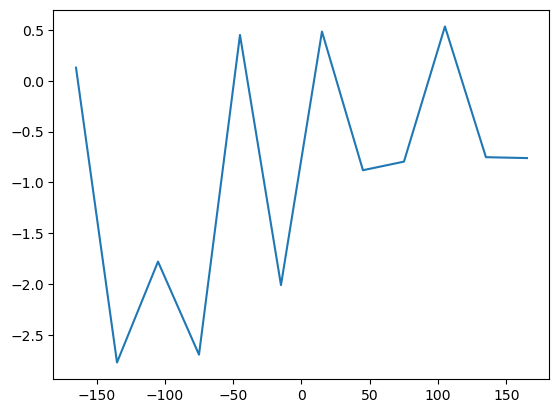

In [234]:
plt.plot(np.unique(df.bin_preDiff ),np.rad2deg(m_err))

In [235]:
df[df.bin_preDiff == t ]

,subj,block,trial,prior,ct,delay,preT,T_Angle,preDiff,err,choiceAngle,keypressed,RT,bin_Tangle,bin_preDiff,bin_err,bin_preDiffbinrads,err_rads


ValueError: x and y must have same first dimension, but have shapes (13,) and (12,)

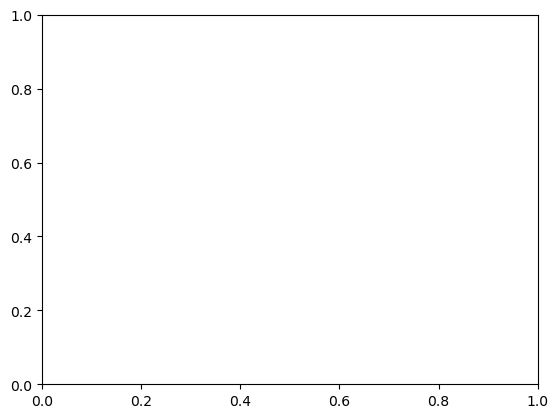

In [236]:
plt.plot(bins,np.rad2deg(m_err))

In [237]:
t

0.2617993877991494

In [238]:
np.unique(df.bin_preDiff )

array([-165., -135., -105.,  -75.,  -45.,  -15.,   15.,   45.,   75.,
        105.,  135.,  165.])

ValueError: x and y must have same first dimension, but have shapes (13,) and (12,)

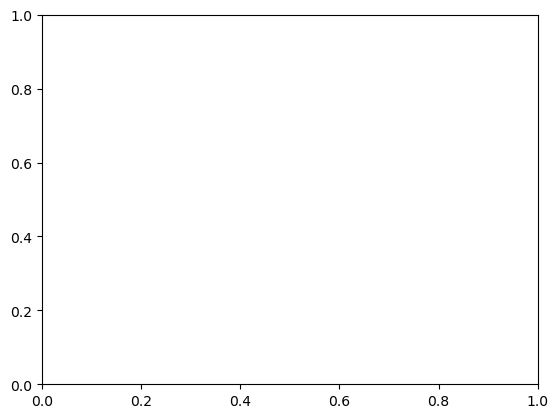

In [239]:
plt.plot(bins,np.rad2deg(m_err))

In [240]:
test

,bin_preDiff,level_1,ref,pred,std_err,lb,hb
0,-165.0,0,-165.411963,-1.778919,14.492773,-16.271691,12.713854
1,-135.0,0,-134.321409,0.451057,8.651990,-8.200933,9.103047
2,-105.0,0,-104.595761,-0.795356,8.414752,-9.210108,7.619395
3,-75.0,0,-75.073861,0.128895,8.504876,-8.375981,8.633770
4,-45.0,0,-43.030681,0.484556,12.039673,-11.555117,12.524229
5,-15.0,0,-14.594859,-0.751558,7.252306,-8.003864,6.500748
6,15.0,0,14.544026,-0.760371,8.816569,-9.576940,8.056198
7,45.0,0,45.248733,-2.694751,8.050188,-10.744938,5.355437
8,75.0,0,74.357397,-2.771706,14.233096,-17.004802,11.461390
9,105.0,0,103.802428,-0.879753,7.666098,-8.545850,6.786345


ValueError: x and y must have same first dimension, but have shapes (76,) and (12,)

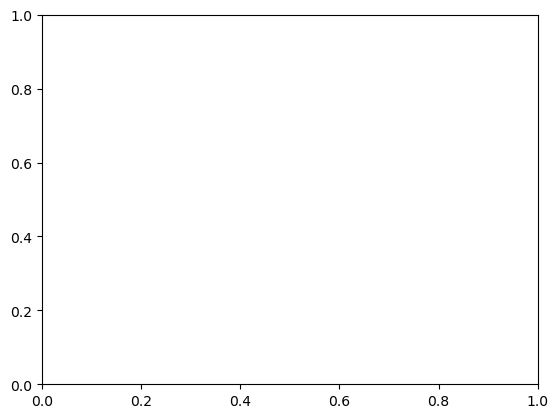

In [241]:
plt.plot(np.rad2deg(xxx+w2/2),np.rad2deg(m_err))

In [242]:
df

,subj,block,trial,prior,ct,delay,preT,T_Angle,preDiff,err,choiceAngle,keypressed,RT,bin_Tangle,bin_preDiff,bin_err,bin_preDiffbinrads,err_rads
0,S01,0,1,0,True,3000,77.308098,139.469019,-62.160921,9.760981,149.23,None,5.749991,135.0,-75.0,15.0,-1.308997,0.170361
1,S01,0,2,0,True,1000,139.469019,78.503047,60.965972,-4.753047,73.75,None,4.33456,75.0,75.0,-15.0,1.308997,-0.082956
2,S01,0,3,0,False,3000,78.503047,-111.634428,-169.862525,-9.785572,-121.42,None,4.166987,-105.0,-165.0,-15.0,-2.879793,-0.170790
3,S01,0,4,0,False,3000,-111.634428,-163.381749,51.747321,14.151749,-149.23,None,3.150066,-165.0,45.0,15.0,0.785398,0.246995
4,S01,0,5,0,False,1000,-163.381749,-35.046439,-128.335310,-12.623561,-47.67,None,6.366445,-45.0,-135.0,-15.0,-2.356194,-0.220323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1362,S03,9,43,141.5,False,1000,121.396988,120.271245,1.125744,-4.921245,115.35,None,1.983785,135.0,15.0,-15.0,0.261799,-0.085892
1363,S03,9,44,141.5,False,3000,120.271245,171.793225,-51.521981,-2.703225,169.09,None,1.500116,165.0,-45.0,-15.0,-0.785398,-0.047180
1364,S03,9,46,141.5,False,1000,100.776084,133.686253,-32.910169,-5.646253,128.04,None,1.833832,135.0,-45.0,-15.0,-0.785398,-0.098546
1365,S03,9,47,141.5,False,3000,133.686253,55.202445,78.483808,-8.642445,46.56,None,1.416754,45.0,75.0,-15.0,1.308997,-0.150839


In [243]:

dat = df[(df['subj'] == 'leentrial')]
dat['prior'].unique()

array([], dtype=object)

In [244]:
dat = df[(df['subj'] == 'leentrial')]
dat = dat[(dat['prior'] == -70.2)]

dat.reset_index(drop=True, inplace=True)

radius = np.sqrt(np.mean(dat.choice_x**2+dat.choice_y**2))
ref_points = np.array([[radius*np.cos(np.deg2rad(dat.T_Angle.iloc[i])), radius*np.sin(np.deg2rad(dat.T_Angle.iloc[i]))] for i in range(len(dat))])
tsr_points = np.array([[dat.choice_x.iloc[j], dat.choice_y.iloc[j]] for j in range(len(dat))])
translation, transformation = compute_affine_transform(ref_points, tsr_points)
ref_centroid = np.mean(ref_points, axis=0)
tsr_centroid = np.mean(tsr_points, axis=0)
new_points = np.empty_like(ref_points)
for j in range(len(dat)):
    new_points[j] = ref_centroid + np.dot(transformation, tsr_points[j] - tsr_centroid)

dat['choiceAngle_corr'] = np.rad2deg(np.arctan2(new_points[:,1], new_points[:,0]))

#sns.set_context('poster')
T = radians(array(dat['T_Angle']))
R = radians(array(dat['choiceAngle']))
P = radians(array(dat['preT']))


figure(figsize=[5,8])
#plt.subplot(4,1,isubj+1)
xxx=arange(-pi,pi-w2+w1,w1)
flip = False
#%%
#figure(figsize=(10,8))
#err,d,m_err,std_err,count,points_idx = compute_serial(R,T,xxx,flip,False)
err,d,m_err,std_err,count,points_idx = compute_serial(R,T,P,xxx,flip,False)
#err,d,m_err,std_err,count,points_idx = compute_serial(R,T,np.zeros(np.shape(R)),xxx,flip,False)
#err,d,m_err,std_err,count,points_idx = compute_serial(R,T,P,xxx,flip,False)

m_err=rad2deg(m_err)
std_err=rad2deg(std_err)

plot(rad2deg(xxx+w2/2),m_err,linewidth=1.5)
fill_between(rad2deg(xxx+w2/2), m_err + std_err, m_err - std_err,alpha=.2)
#errorbar(xxx+w2/2,m_err,std_err)
plot(rad2deg(xxx+w2/2),zeros(len(xxx)),"k--",linewidth=1)

xlabel(r'$\theta_{n-1}^S - \theta_n^S$ ($^o$)', fontsize=14); ylabel(r'$\theta_n^e$ ($^o$)', fontsize=14);
sns.despine()


adict={}
adict['m_err']=m_err
adict['std_err']=std_err
adict['xxx']=xxx
adict['w2']=w2

AttributeError: 'DataFrame' object has no attribute 'choice_x'

In [245]:

figure(figsize=[5,8])
#plt.subplot(4,1,isubj+1)
xxx=arange(-pi,pi-w2+w1,w1)
flip = False
#%%
#figure(figsize=(10,8))
#err,d,m_err,std_err,count,points_idx = compute_serial(R,T,xxx,flip,False)
err,d,m_err,std_err,count,points_idx = compute_serial(R,T,np.zeros(np.shape(R)),xxx,flip,False)
#err,d,m_err,std_err,count,points_idx = compute_serial(R,T,P,xxx,flip,False)

m_err=rad2deg(m_err)
std_err=rad2deg(std_err)

plot(rad2deg(xxx+w2/2),m_err,linewidth=1.5)
fill_between(rad2deg(xxx+w2/2), m_err + std_err, m_err - std_err,alpha=.2)
#errorbar(xxx+w2/2,m_err,std_err)
plot(rad2deg(xxx+w2/2),zeros(len(xxx)),"k--",linewidth=1)

xlabel(r'$\theta_{n-1}^S - \theta_n^S$ ($^o$)', fontsize=14); ylabel(r'$\theta_n^e$ ($^o$)', fontsize=14);
sns.despine()


adict={}
adict['m_err']=m_err
adict['std_err']=std_err
adict['xxx']=xxx
adict['w2']=w2

IndexError: arrays used as indices must be of integer (or boolean) type

<Figure size 500x800 with 0 Axes>